In [209]:
#imports
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import os

/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/bstc/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bstc/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bstc/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/

<hr>

# Defining the model

In the cells below, we will:
- define and tweak hyperparameters
- build a PyTorch RNN model class

### Hyperparameters

In [45]:
batch_size = 1000       # num of training examples to train on in a batch
limit_timesteps = 20    # sequence length
num_hidden_layers = 300
state_dim = 3           # dimensions of the state variable passed as input to the LSTM model
future = 10
epochs = 100
csvname1 = 'states_2017-08-28-00.csv'
csvname2 = 'states_2017-10-02-00.csv'
filename = '8-28_10-02'

### Define PyTorch RNN Model

In [46]:
# Sequence model
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(state_dim, num_hidden_layers)         # layer 1
        self.lstm2 = nn.LSTMCell(num_hidden_layers, num_hidden_layers) # layer 2
        self.linear = nn.Linear(num_hidden_layers, state_dim)          # Fully convolutional layer

    def forward(self, input, future = 0):
        outputs = []
        
        # hidden parameters of LSTM model
        h_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), num_hidden_layers).double(), requires_grad=False)
        
        # Forward pass through LSTM layers
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            input_t = input_t.squeeze(1)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            if (future == 0):
                outputs += [output]
        
        # Predicting future time steps
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

<hr>

# Loading data

In the cells below, we will:
- load in data for training
- normalize the data to make dimensions scale relative to each other

### Load data that will be used to train the model

In [212]:
# load data and make training set
data1 = pd.read_csv('cleaned/' + csvname1)
data2 = pd.read_csv('cleaned/' + csvname2)

data = data1.append(data2)

all_planes = []

count = 0
unique_icao = data.icao24.unique()

# get time step rows for each unique plane 
for i, name in enumerate(unique_icao):
    if count % 100 == 0: print(count)
    # only get batch size for now
    if count >= batch_size:
        break
    
    # get rows where icao == name (boolean vector)
    selector = data['icao24'] == name
    
    one_plane_df = data[selector]
    one_plane_df = one_plane_df.drop(['icao24','time','lat','lon','velocity','heading'], axis=1)
    one_plane_arr = one_plane_df.as_matrix()
    one_plane_arr = one_plane_arr[0:limit_timesteps]
    
    all_planes.append(one_plane_arr)
    
    count += 1

# all planes are batched as one 
batch = np.asarray(all_planes) 

0
100
200
300
400
500
600
700
800
900
1000


### Normalize data

In [213]:
# Normalize the x_displacement, y_displacement, geoaltitude and save data that may need to be used in other files
flat_batch = np.reshape(batch, (-1, state_dim))
means = np.mean(flat_batch, axis=0)
stdevs = np.std(flat_batch, axis=0)
batch -= means
batch /= stdevs

# save the means and stdevs to be denormalized in policy_generation
np.save(filename + "_model_means", means)
np.save(filename + "_model_stdevs", stdevs)

print(means)
print(stdevs)

[  6.21941504e+03  -7.16439857e-04   1.39462928e-03]
[  4.54121872e+03   1.25794934e-01   7.07828114e-02]


<hr>

# Building and Training

In the cells below we will:

- initialize PyTorch variables for input/target/test
- build and train our LSTM model
  - make predictions with the LSTM model to see test loss and model loss
- Use trained LSTM model to visualize prediction of plane's future time step trajectory
  - visualizations on both normalized and denormalized data

### Declare PyTorch input/target/test variables

In [214]:
input = Variable(torch.from_numpy(batch[100:,:-1,:]), requires_grad=False)
target = Variable(torch.from_numpy(batch[100:,1:,:]), requires_grad=False)
test_input = Variable(torch.from_numpy(batch[:100,:-future,:]), requires_grad=False)
test_target = Variable(torch.from_numpy(batch[:100,-future:,:]), requires_grad=False)

print(batch.shape)

[[ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -5.06681263e-02  -3.35848153e+01   2.75911843e+01]
 [ -8.42273996e-02  -3.11501364e-01   1.04466509e-01]
 [ -1.36244273e-01  -8.06002143e-02   1.46826171e-02]
 [ -1.79871328e-01  -2.13266570e-01   6.51374158e-02]
 [ -2.10074674e-01  -1.57261129e-01   3.37442929e-02]
 [ -2.40278020e-01  -2.11256

In [47]:
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

losses = []
test_losses = []

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# begin to train
for i in range(epochs):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
#         print('loss:', loss.data.numpy()[0])
        losses.append(loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    
    # begin to predict
    pred = seq(test_input, future = future)
#     pred1 = seq(test_input[:1, :, :])
    loss = criterion(pred, test_target)
    print('test loss:', loss.data.numpy()[0])
    test_losses.append(loss.data.numpy()[0])
    y = pred.data.numpy()
    if i % 10 == 0:
        torch.save(seq.state_dict(), filename + 'params_epochs={}_H={}_epoch{}.pt'.format(epochs,num_hidden_layers,i))
print(pred)

np.save("losses_epochs={}_H={}".format(epochs,num_hidden_layers), np.asarray(losses))
np.save("test_losses_epochs={}_H={}".format(epochs,num_hidden_layers), np.asarray(test_losses))

#     # draw the result
#     plt.figure(figsize=(30,10))
#     plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
#     plt.xlabel('x', fontsize=20)
#     plt.ylabel('y', fontsize=20)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     def draw(yi, color):
#         plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
#         plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
#     draw(y[0], 'r')
#     draw(y[1], 'g')
#     draw(y[2], 'b')
#     plt.savefig('predict%d.pdf'%i)
#     plt.close()


STEP:  0
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([100, 10, 3])
test loss: 2.60693024562
STEP:  1
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.S

torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([100, 10, 3])
test loss: 1.84132527783
STEP:  15
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([100, 10, 3])
test loss: 1.85770367076
STEP:  16
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
loss: 0.00789330165385
torch.Size([900, 19, 3])
torch.Size([900, 19, 3])
torch.S

1468 97


<IPython.core.display.Javascript object>


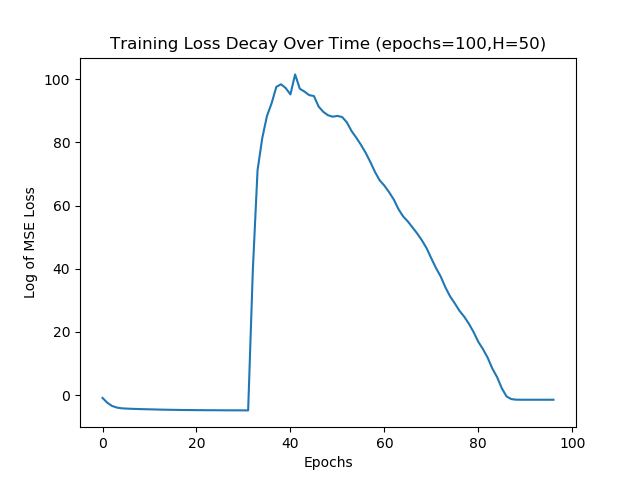

In [56]:
losses = np.load("losses_epochs={}_H={}.npy".format(epochs,num_hidden_layers))

# losses = [float(line[6:]) for line in s.split('\n') if line[:4] == 'loss']
aggregated_losses = []
aggregate = []
for loss in losses:
    aggregate.append(loss)
    if(len(aggregate) == 15):
        aggregated_losses.append(np.mean(aggregate))
        aggregate = []
        
print(len(losses), len(aggregated_losses))
plt.title("Training Loss Decay Over Time (epochs=100,H=50)".format(len(aggregated_losses), num_hidden_layers))
plt.xlabel("Epochs")
plt.ylabel("Log of MSE Loss")
#plt.clf()
plt.plot(np.log(aggregated_losses))
plt.show()


torch.Size([100, 10, 3])
test_input Variable containing:
 0.9108 -0.1892  0.0520
 0.9108 -0.1911  0.0527
 0.9108 -0.1831  0.0493
 0.9108 -0.1723  0.0458
 0.9108 -0.1892  0.0514
 0.9108 -0.1949  0.0534
 0.9108 -0.1762  0.0462
 0.9108 -0.1873  0.0505
 0.9108 -0.1838  0.0491
 0.9108 -0.1916  0.0516
[torch.DoubleTensor of size 10x3]

test_target Variable containing:
 0.9108 -0.1762  0.0461
 0.9108 -0.1914  0.0513
 0.9108 -0.1915  0.0516
 0.9108 -0.1844  0.0491
 0.9108 -0.1859  0.0500
 0.9108 -0.1840  0.0507
 0.9108 -0.1888  0.0618
 0.9108 -0.1730  0.0592
 0.9108 -0.1916  0.0689
 0.9108 -0.1880  0.0683
[torch.DoubleTensor of size 10x3]

batch [[ 0.91080505 -0.18916111  0.05198387]
 [ 0.91080505 -0.19112173  0.05269636]
 [ 0.91080505 -0.18308091  0.04929836]
 [ 0.91080505 -0.17225555  0.04581267]
 [ 0.91080505 -0.18919162  0.05143581]
 [ 0.91080505 -0.19491327  0.05344172]
 [ 0.91080505 -0.17619204  0.04619631]
 [ 0.91080505 -0.18729967  0.05053698]
 [ 0.91080505 -0.18380565  0.04910105]
 [ 

/home/bstc/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


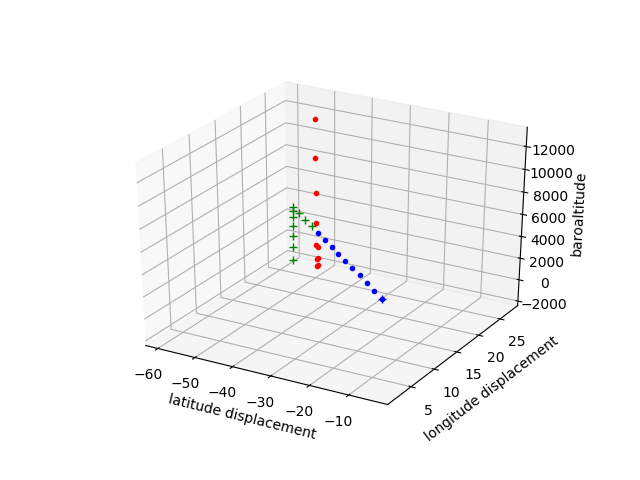

[[ 0.91080505 -0.18916111  0.05198387]
 [ 0.91080505 -0.19112173  0.05269636]
 [ 0.91080505 -0.18308091  0.04929836]
 [ 0.91080505 -0.17225555  0.04581267]
 [ 0.91080505 -0.18919162  0.05143581]
 [ 0.91080505 -0.19491327  0.05344172]
 [ 0.91080505 -0.17619204  0.04619631]
 [ 0.91080505 -0.18729967  0.05053698]
 [ 0.91080505 -0.18380565  0.04910105]
 [ 0.91080505 -0.19163286  0.0515783 ]]
Variable containing:
 0.9108 -0.1892  0.0520
 0.9108 -0.1911  0.0527
 0.9108 -0.1831  0.0493
 0.9108 -0.1723  0.0458
 0.9108 -0.1892  0.0514
 0.9108 -0.1949  0.0534
 0.9108 -0.1762  0.0462
 0.9108 -0.1873  0.0505
 0.9108 -0.1838  0.0491
 0.9108 -0.1916  0.0516
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.90121444 -0.17435625  0.17543727]
 [ 0.89204018 -0.16373547  0.22505931]
 [ 0.88136497 -0.15012577  0.27268791]
 [ 0.86920104 -0.13395672  0.31810246]
 [ 0.85566579 -0.11548094  0.36113846]
 [ 0.84089914 -0.09489654  0.40171102]
 [ 0.82504649 -0.0723761   0.43976629]
 [ 0.80825331 -0.048079

<IPython.core.display.Javascript object>


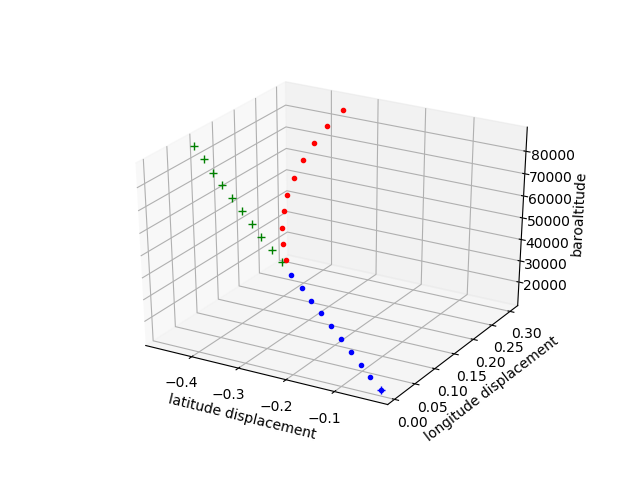

[[ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]
 [ 0.97960156  0.15995136 -0.29737423]]
Variable containing:
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
 0.9796  0.1600 -0.2974
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.97240876  0.13689681 -0.16121105]
 [ 0.96609652  0.12882667 -0.10695616]
 [ 0.95914833  0.12324576 -0.05524909]
 [ 0.95136628  0.11984027 -0.00564769]
 [ 0.94268578  0.11854763  0.04170688]
 [ 0.93308443  0.11928927  0.08685265]
 [ 0.92255444  0.12198656  0.12982244]
 [ 0.9110999   0.126550

<IPython.core.display.Javascript object>


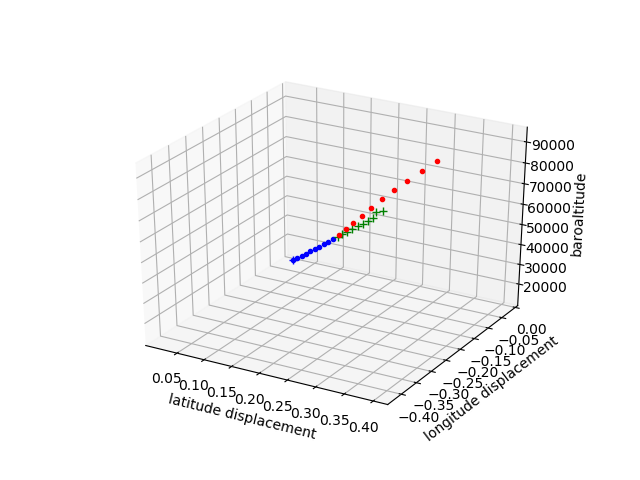

[[ 1.11216069 -0.16999066 -0.19201435]
 [ 1.11048273 -0.17151395 -0.1933297 ]
 [ 1.11048273 -0.16897514 -0.190699  ]
 [ 1.11048273 -0.17405277 -0.19530274]
 [ 1.11048273 -0.17372965 -0.19734154]
 [ 1.11048273 -0.16980602 -0.19655232]
 [ 1.11048273 -0.16999066 -0.19661809]
 [ 1.11216069 -0.1730834  -0.19883227]
 [ 1.11216069 -0.16450913 -0.19108264]
 [ 1.11383865 -0.17898038 -0.20520078]]
Variable containing:
 1.1122 -0.1700 -0.1920
 1.1105 -0.1715 -0.1933
 1.1105 -0.1690 -0.1907
 1.1105 -0.1741 -0.1953
 1.1105 -0.1737 -0.1973
 1.1105 -0.1698 -0.1966
 1.1105 -0.1700 -0.1966
 1.1122 -0.1731 -0.1988
 1.1122 -0.1645 -0.1911
 1.1138 -0.1790 -0.2052
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.12809565 -0.18596857 -0.05795029]
 [ 1.12899793 -0.18671216 -0.00176059]
 [ 1.12842136 -0.18392265  0.05167219]
 [ 1.12618189 -0.17816455  0.10254569]
 [ 1.12226338 -0.16976148  0.15084582]
 [ 1.11669105 -0.15898891  0.19666607]
 [ 1.10950974 -0.14608994  0.24010703]
 [ 1.10077913 -0.131288

<IPython.core.display.Javascript object>


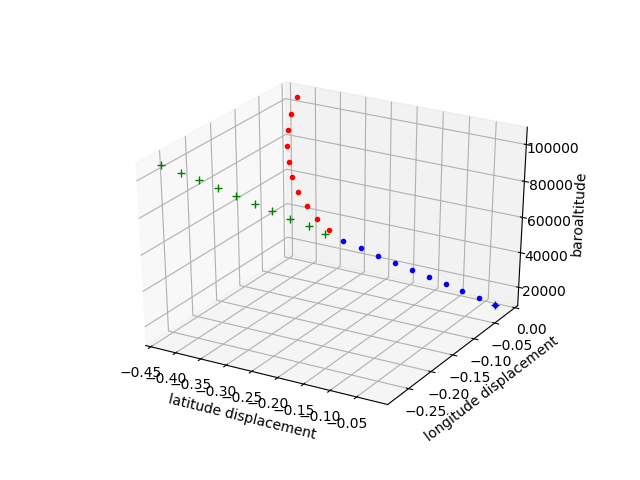

[[-0.52217592  0.17176915  0.04312715]
 [-0.54231148  0.1985479   0.05360614]
 [-0.56244704  0.18297768  0.04732533]
 [-0.58090464  0.182965    0.0469088 ]
 [-0.59768428  0.17834972  0.04593324]
 [-0.61110799  0.17663801  0.06645277]
 [-0.62117577  0.15640181  0.10394037]
 [-0.62956559  0.13053597  0.12328704]
 [-0.63459948  0.12682093  0.12516142]
 [-0.65809097  0.12611089  0.1251943 ]]
Variable containing:
-0.5222  0.1718  0.0431
-0.5423  0.1985  0.0536
-0.5624  0.1830  0.0473
-0.5809  0.1830  0.0469
-0.5977  0.1783  0.0459
-0.6111  0.1766  0.0665
-0.6212  0.1564  0.1039
-0.6296  0.1305  0.1233
-0.6346  0.1268  0.1252
-0.6581  0.1261  0.1252
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-0.70146028  0.21948913  0.17479497]
 [-0.72537688  0.25813402  0.19419326]
 [-0.75033829  0.29570179  0.21198029]
 [-0.77657735  0.33148871  0.22801873]
 [-0.80422154  0.36524156  0.24197338]
 [-0.83332632  0.39671267  0.25381897]
 [-0.86389939  0.42576927  0.26353261]
 [-0.8959131   0.452336

<IPython.core.display.Javascript object>


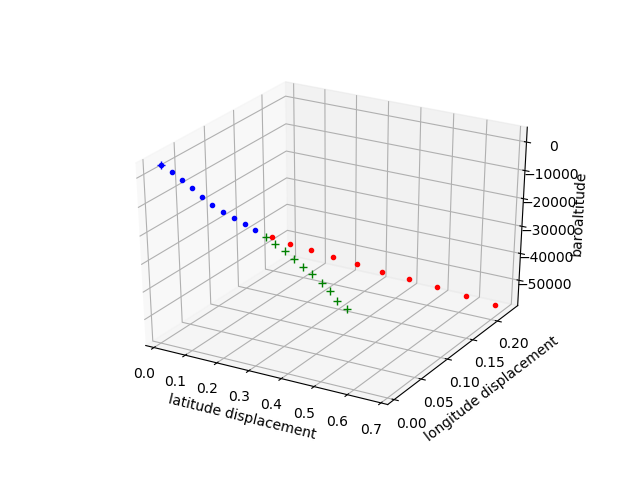

[[ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]
 [ 1.11383865  0.04510265 -0.51702744]]
Variable containing:
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
 1.1138  0.0451 -0.5170
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.12685038 -0.00126271 -0.34201488]
 [ 1.12926959 -0.01797948 -0.273484  ]
 [ 1.13133951 -0.030962   -0.20907025]
 [ 1.13267468 -0.04067212 -0.14799504]
 [ 1.13306788 -0.04725554 -0.0902717 ]
 [ 1.13238097 -0.05088949 -0.03570642]
 [ 1.13050898 -0.05175751  0.01587876]
 [ 1.12737758 -0.050060

<IPython.core.display.Javascript object>


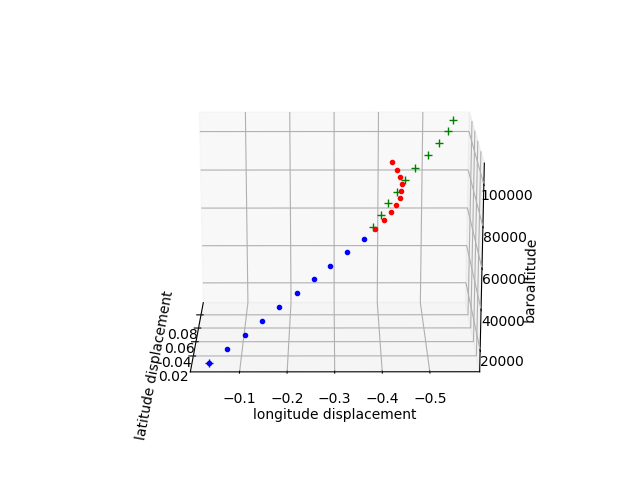

[[ 1.24975371  0.10650244 -0.26804183]
 [ 1.24975371  0.12150939 -0.30274526]
 [ 1.24975371  0.11201644 -0.28343148]
 [ 1.24975371  0.11757083 -0.29684809]
 [ 1.24975371  0.11300613 -0.28485644]
 [ 1.24975371  0.11439977 -0.28550316]
 [ 1.24975371  0.11258197 -0.28493317]
 [ 1.24975371  0.11296573 -0.28477971]
 [ 1.24807575  0.11207703 -0.2829163 ]
 [ 1.23800797  0.10464424 -0.26610168]]
Variable containing:
 1.2498  0.1065 -0.2680
 1.2498  0.1215 -0.3027
 1.2498  0.1120 -0.2834
 1.2498  0.1176 -0.2968
 1.2498  0.1130 -0.2849
 1.2498  0.1144 -0.2855
 1.2498  0.1126 -0.2849
 1.2498  0.1130 -0.2848
 1.2481  0.1121 -0.2829
 1.2380  0.1046 -0.2661
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.25040125  0.09312306 -0.15001336]
 [ 1.2506657   0.08829049 -0.1021413 ]
 [ 1.24990788  0.08540597 -0.05643071]
 [ 1.24803706  0.08422375 -0.0128682 ]
 [ 1.24503952  0.08460136  0.02857652]
 [ 1.24091176  0.08641488  0.0679931 ]
 [ 1.23565785  0.08954854  0.1054829 ]
 [ 1.22929081  0.093891

<IPython.core.display.Javascript object>


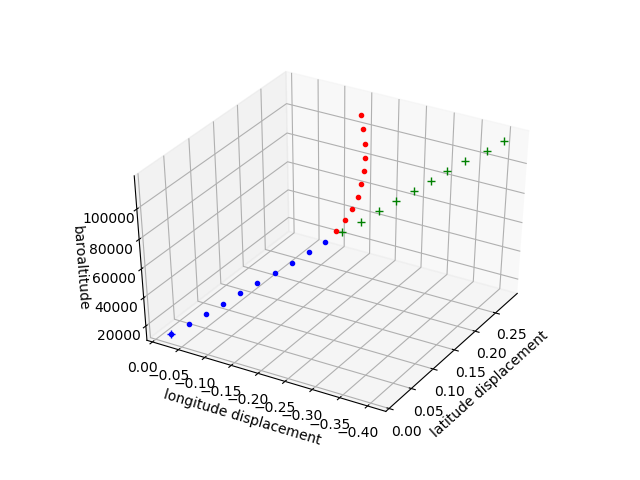

[[-1.17658174  0.09217602 -0.01226022]
 [-1.15141229  0.0999254  -0.00786475]
 [-1.13463265  0.09090902 -0.00988162]
 [-1.12288691  0.10310766 -0.0100022 ]
 [-1.10778523  0.10748326 -0.00765648]
 [-1.09268356  0.11440761 -0.00717419]
 [-1.07925985  0.11934305 -0.0100022 ]
 [-1.06751411  0.12520665 -0.0051025 ]
 [-1.04737854  0.14761503 -0.00523404]
 [-1.03227687  0.13899642 -0.01575687]]
Variable containing:
-1.1766  0.0922 -0.0123
-1.1514  0.0999 -0.0079
-1.1346  0.0909 -0.0099
-1.1229  0.1031 -0.0100
-1.1078  0.1075 -0.0077
-1.0927  0.1144 -0.0072
-1.0793  0.1193 -0.0100
-1.0675  0.1252 -0.0051
-1.0474  0.1476 -0.0052
-1.0323  0.1390 -0.0158
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-1.10000691  0.232133    0.04980555]
 [-1.12819622  0.27100136  0.07000427]
 [-1.15584211  0.30825461  0.08705464]
 [-1.18390957  0.34298143  0.10137337]
 [-1.21272314  0.37525482  0.11250742]
 [-1.24221248  0.40506205  0.12050045]
 [-1.27213569  0.43252721  0.1254308 ]
 [-1.30219798  0.457804

<IPython.core.display.Javascript object>


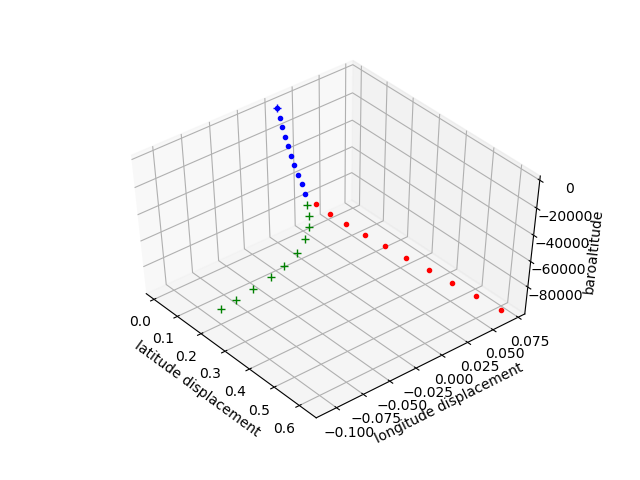

[[ 0.97960156  0.04610115 -0.30096953]
 [ 0.97960156  0.04608784 -0.30184644]
 [ 0.97960156  0.04499615 -0.29790037]
 [ 0.97960156  0.04269295 -0.28139268]
 [ 0.97960156  0.05002857 -0.32953464]
 [ 0.97960156  0.04496952 -0.29708924]
 [ 0.97960156  0.04616772 -0.30490464]
 [ 0.9779236   0.04457012 -0.29649733]
 [ 0.9779236   0.04591477 -0.30166009]
 [ 0.9779236   0.0462178  -0.30556231]]
Variable containing:
 0.9796  0.0461 -0.3010
 0.9796  0.0461 -0.3018
 0.9796  0.0450 -0.2979
 0.9796  0.0427 -0.2814
 0.9796  0.0500 -0.3295
 0.9796  0.0450 -0.2971
 0.9796  0.0462 -0.3049
 0.9779  0.0446 -0.2965
 0.9779  0.0459 -0.3017
 0.9779  0.0462 -0.3056
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.97595455  0.02081471 -0.15511367]
 [ 0.97138649  0.01268268 -0.09597661]
 [ 0.96605714  0.00767217 -0.03984536]
 [ 0.95972995  0.00534681  0.0138859 ]
 [ 0.952324    0.00558987  0.06508292]
 [ 0.94380875  0.00826898  0.11381474]
 [ 0.93417441  0.01326092  0.16013123]
 [ 0.92342844  0.020434

<IPython.core.display.Javascript object>


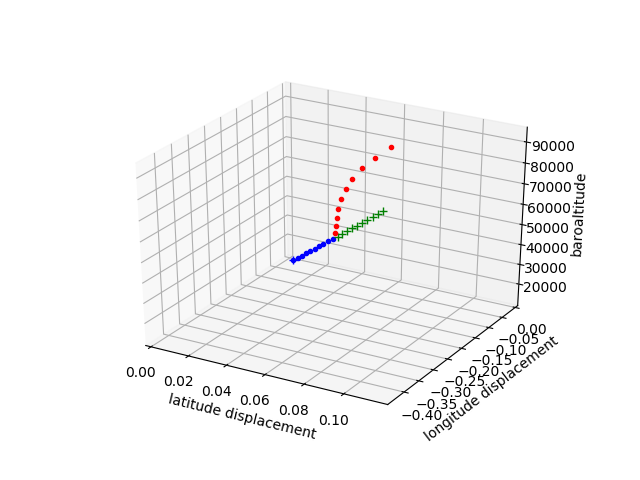

[[ 1.11383865  0.21506287 -0.22083157]
 [ 1.11383865  0.182965   -0.18938364]
 [ 1.11383865  0.19596131 -0.20187951]
 [ 1.11383865  0.18738979 -0.19427238]
 [ 1.11383865  0.18696666 -0.19366951]
 [ 1.11383865  0.1948128  -0.20257007]
 [ 1.11383865  0.18660397 -0.19332971]
 [ 1.11383865  0.18506859 -0.19286933]
 [ 1.11551662  0.1985364  -0.20628595]
 [ 1.11551662  0.18452456 -0.19201435]]
Variable containing:
 1.1138  0.2151 -0.2208
 1.1138  0.1830 -0.1894
 1.1138  0.1960 -0.2019
 1.1138  0.1874 -0.1943
 1.1138  0.1870 -0.1937
 1.1138  0.1948 -0.2026
 1.1138  0.1866 -0.1933
 1.1138  0.1851 -0.1929
 1.1155  0.1985 -0.2063
 1.1155  0.1845 -0.1920
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.11334549  0.17737851 -0.08452758]
 [ 1.10923728  0.17411358 -0.04075202]
 [ 1.10434353  0.1725053   0.00143605]
 [ 1.09853581  0.1723581   0.04191726]
 [ 1.09179412  0.17357836  0.08065026]
 [ 1.08411887  0.17609486  0.11764503]
 [ 1.07551849  0.17983887  0.15293866]
 [ 1.06600742  0.184741

<IPython.core.display.Javascript object>


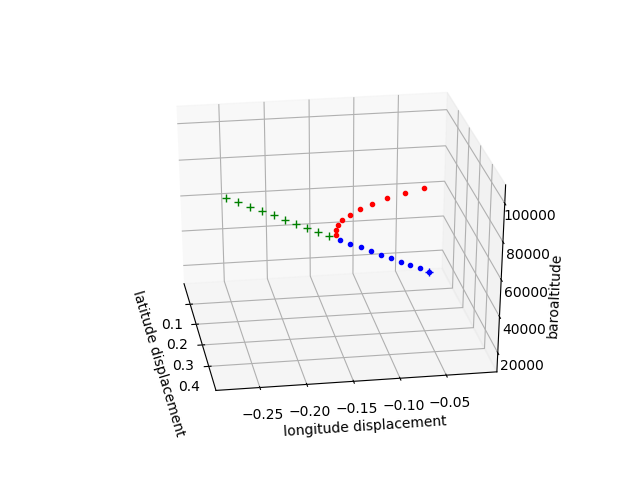

[[ 0.84536447  0.171549   -0.00537654]
 [ 0.84536447  0.1649315  -0.00547519]
 [ 0.84536447  0.18902397 -0.00418176]
 [ 0.84536447  0.15497222 -0.00656036]
 [ 0.84536447  0.17500305 -0.00589172]
 [ 0.84536447  0.18552369 -0.00526692]
 [ 0.84536447  0.1649315  -0.00676862]
 [ 0.84536447  0.18864753 -0.00547519]
 [ 0.84536447  0.16167558 -0.00737149]
 [ 0.84536447  0.19607076 -0.00523404]]
Variable containing:
 0.8454  0.1715 -0.0054
 0.8454  0.1649 -0.0055
 0.8454  0.1890 -0.0042
 0.8454  0.1550 -0.0066
 0.8454  0.1750 -0.0059
 0.8454  0.1855 -0.0053
 0.8454  0.1649 -0.0068
 0.8454  0.1886 -0.0055
 0.8454  0.1617 -0.0074
 0.8454  0.1961 -0.0052
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.81911961  0.19024053  0.09547937]
 [ 0.8051946   0.19306509  0.13592405]
 [ 0.79059943  0.19787331  0.17387257]
 [ 0.77523738  0.2042888   0.21020876]
 [ 0.75913464  0.21229442  0.24460797]
 [ 0.74235236  0.22182451  0.27705544]
 [ 0.72495998  0.23282499  0.30749275]
 [ 0.70702776  0.245230

<IPython.core.display.Javascript object>


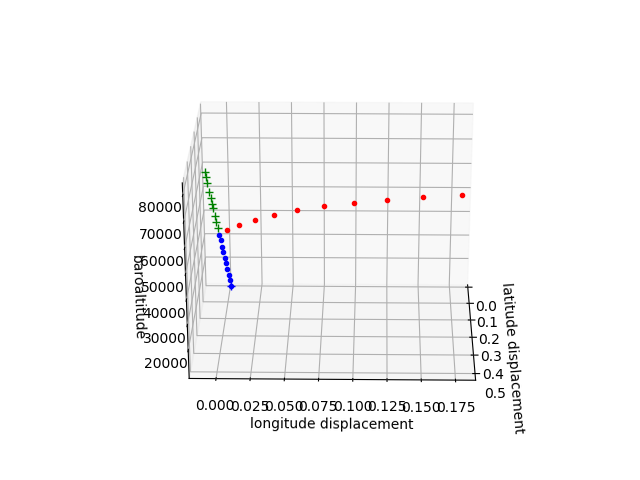

[[ 1.04672011 -0.08519426  0.23744883]
 [ 1.04672011 -0.08113216  0.226926  ]
 [ 1.04672011 -0.08824084  0.24797166]
 [ 1.04672011 -0.0846865   0.23810651]
 [ 1.04839807 -0.08675217  0.24249102]
 [ 1.04839807 -0.0811437   0.22798924]
 [ 1.04839807 -0.08511348  0.23768998]
 [ 1.04839807 -0.08624441  0.24294043]
 [ 1.04839807 -0.08695989  0.24214026]
 [ 1.04839807 -0.0811437   0.22734252]]
Variable containing:
 1.0467 -0.0852  0.2374
 1.0467 -0.0811  0.2269
 1.0467 -0.0882  0.2480
 1.0467 -0.0847  0.2381
 1.0484 -0.0868  0.2425
 1.0484 -0.0811  0.2280
 1.0484 -0.0851  0.2377
 1.0484 -0.0862  0.2429
 1.0484 -0.0870  0.2421
 1.0484 -0.0811  0.2273
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.03080008 -0.05213534  0.31835521]
 [ 1.0189192  -0.03684998  0.3533246 ]
 [ 1.00589002 -0.01973549  0.3869588 ]
 [ 0.99169598 -0.00117442  0.4191038 ]
 [ 0.97643447  0.01863695  0.44957729]
 [ 0.9602226   0.03955281  0.47829681]
 [ 0.94317881  0.0614554   0.50520821]
 [ 0.92541678  0.084241

<IPython.core.display.Javascript object>


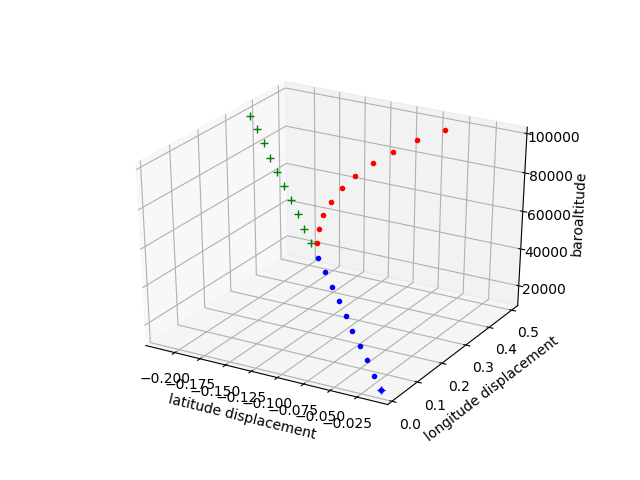

[[ 1.20948258  0.04712354 -0.30710785]
 [ 1.21619444  0.0247299  -0.17820313]
 [ 1.22961815  0.0437645  -0.31631533]
 [ 1.24304186  0.05888021 -0.3978673 ]
 [ 1.24807575  0.04432434 -0.32749584]
 [ 1.24975371  0.0476414  -0.322355  ]
 [ 1.24807575  0.04156712 -0.30304122]
 [ 1.24807575  0.04488418 -0.30184644]
 [ 1.24807575  0.04488418 -0.31697301]
 [ 1.24807575  0.04100728 -0.28029655]]
Variable containing:
 1.2095  0.0471 -0.3071
 1.2162  0.0247 -0.1782
 1.2296  0.0438 -0.3163
 1.2430  0.0589 -0.3979
 1.2481  0.0443 -0.3275
 1.2498  0.0476 -0.3224
 1.2481  0.0416 -0.3030
 1.2481  0.0449 -0.3018
 1.2481  0.0449 -0.3170
 1.2481  0.0410 -0.2803
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.25968601  0.02452174 -0.1585537 ]
 [ 1.26115724  0.01937544 -0.10760566]
 [ 1.2615484   0.01658268 -0.0592487 ]
 [ 1.26072511  0.01584332 -0.01331236]
 [ 1.2586492   0.01697559  0.03026312]
 [ 1.25530813  0.01981321  0.07160162]
 [ 1.25070445  0.0242      0.11083046]
 [ 1.24485417  0.029986

<IPython.core.display.Javascript object>


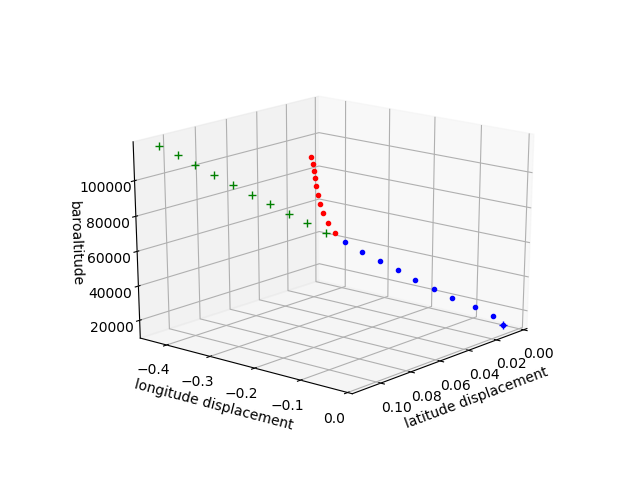

[[ 1.1809572  -0.03742646  0.25980985]
 [ 1.1809572  -0.03797231  0.26112521]
 [ 1.1809572  -0.03797231  0.25783682]
 [ 1.1809572  -0.03797231  0.26638662]
 [ 1.1809572  -0.03742646  0.2584945 ]
 [ 1.1809572  -0.03797231  0.25389076]
 [ 1.1809572  -0.03818532  0.26702238]
 [ 1.1809572  -0.03797231  0.25644474]
 [ 1.1809572  -0.0377593   0.25859315]
 [ 1.1809572  -0.03797231  0.26835966]]
Variable containing:
 1.1810 -0.0374  0.2598
 1.1810 -0.0380  0.2611
 1.1810 -0.0380  0.2578
 1.1810 -0.0380  0.2664
 1.1810 -0.0374  0.2585
 1.1810 -0.0380  0.2539
 1.1810 -0.0382  0.2670
 1.1810 -0.0380  0.2564
 1.1810 -0.0378  0.2586
 1.1810 -0.0380  0.2684
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.15950218 -0.00794286  0.3371445 ]
 [ 1.14707032  0.00690143  0.36598783]
 [ 1.13360425  0.02287269  0.39411169]
 [ 1.1191193   0.03974093  0.42109703]
 [ 1.10369254  0.05735421  0.4468496 ]
 [ 1.08741614  0.07561563  0.47129574]
 [ 1.07038185  0.09444982  0.4944044 ]
 [ 1.05267763  0.113796

<IPython.core.display.Javascript object>


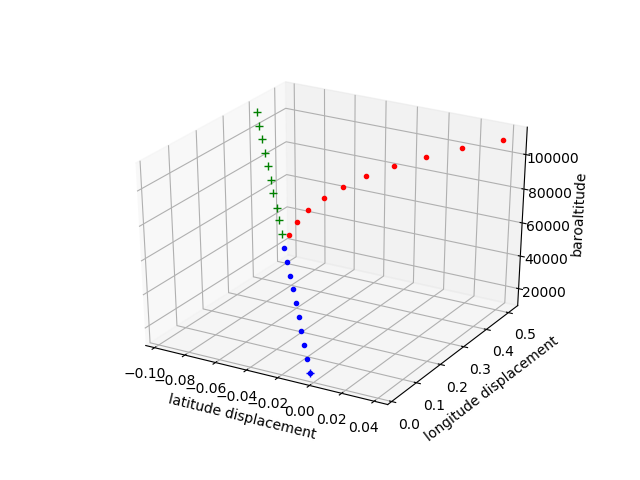

[[-1.01381927 -0.09659252 -0.00773321]
 [-1.02053112 -0.1172635   0.01327957]
 [-1.02724298 -0.10730422  0.01133943]
 [-1.02892094 -0.04165916 -0.00691112]
 [-1.03898872 -0.15026045  0.0223884 ]
 [-1.04402261 -0.09513556  0.0069001 ]
 [-1.05073447 -0.08125687  0.00422555]
 [-1.05744632 -0.09971847  0.00868679]
 [-1.06415818 -0.08904782  0.00660415]
 [-1.07422596 -0.0785208   0.00528879]]
Variable containing:
-1.0138 -0.0966 -0.0077
-1.0205 -0.1173  0.0133
-1.0272 -0.1073  0.0113
-1.0289 -0.0417 -0.0069
-1.0390 -0.1503  0.0224
-1.0440 -0.0951  0.0069
-1.0507 -0.0813  0.0042
-1.0574 -0.0997  0.0087
-1.0642 -0.0890  0.0066
-1.0742 -0.0785  0.0053
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-1.1118699   0.02583252  0.07850087]
 [-1.13250487  0.07038951  0.10420092]
 [-1.15431981  0.11393273  0.12571863]
 [-1.1775138   0.15507051  0.14408271]
 [-1.20205379  0.19389449  0.15874561]
 [-1.22778442  0.23022609  0.16993184]
 [-1.25448661  0.26413327  0.177737  ]
 [-1.28190857  0.295709

<IPython.core.display.Javascript object>


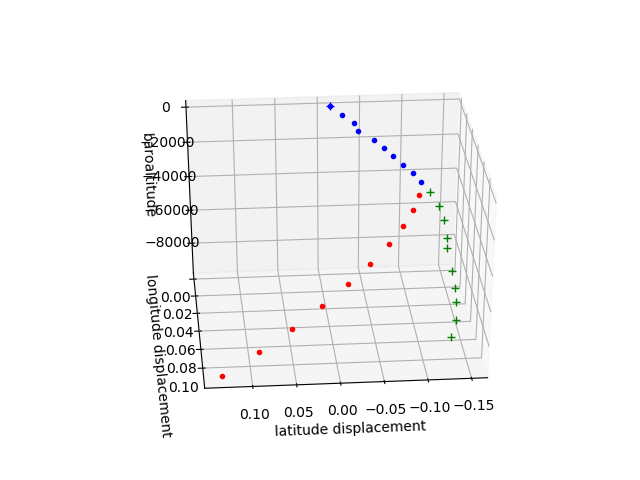

[[ 0.97960156  0.18960312  0.11380552]
 [ 0.97960156  0.1791061   0.11249017]
 [ 0.97960156  0.1783614   0.1112077 ]
 [ 0.97960156  0.19706591  0.12495315]
 [ 0.97960156  0.16572536  0.10144119]
 [ 0.97960156  0.197668    0.12580813]
 [ 0.97960156  0.1634279   0.09904067]
 [ 0.97960156  0.18750371  0.11840927]
 [ 0.97960156  0.23411049  0.15326615]
 [ 0.97960156  0.18078562  0.11249017]]
Variable containing:
 0.9796  0.1896  0.1138
 0.9796  0.1791  0.1125
 0.9796  0.1784  0.1112
 0.9796  0.1971  0.1250
 0.9796  0.1657  0.1014
 0.9796  0.1977  0.1258
 0.9796  0.1634  0.0990
 0.9796  0.1875  0.1184
 0.9796  0.2341  0.1533
 0.9796  0.1808  0.1125
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.96070734  0.20450347  0.19934359]
 [ 0.94860894  0.21077449  0.22991673]
 [ 0.93579857  0.21838338  0.26006421]
 [ 0.92218932  0.22718337  0.28890669]
 [ 0.90780789  0.23704432  0.31640657]
 [ 0.89270894  0.24790751  0.34243628]
 [ 0.8769543   0.25971681  0.36694733]
 [ 0.86060622  0.272420

<IPython.core.display.Javascript object>


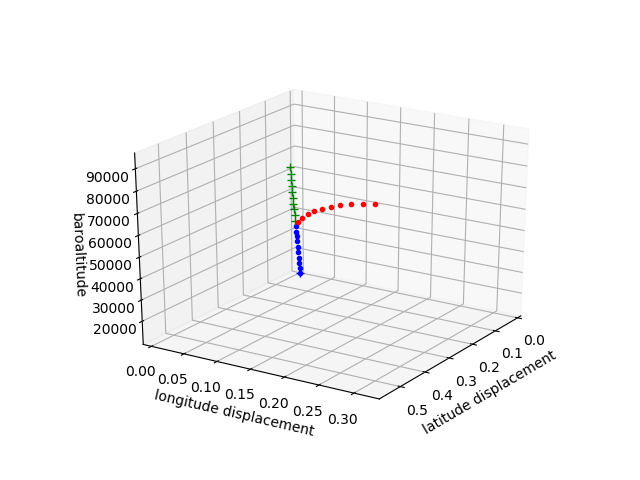

[[ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]
 [ 0.42587355  0.22526922  0.13162858]]
Variable containing:
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
 0.4259  0.2253  0.1316
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 0.37850029  0.24593294  0.20878236]
 [ 0.35570176  0.2588536   0.23847267]
 [ 0.33295855  0.27390972  0.26590495]
 [ 0.31023806  0.29069968  0.29108657]
 [ 0.28756715  0.30904449  0.31377924]
 [ 0.264992    0.3287518   0.3339524 ]
 [ 0.24255504  0.34963284  0.35162496]
 [ 0.22028301  0.371491

<IPython.core.display.Javascript object>


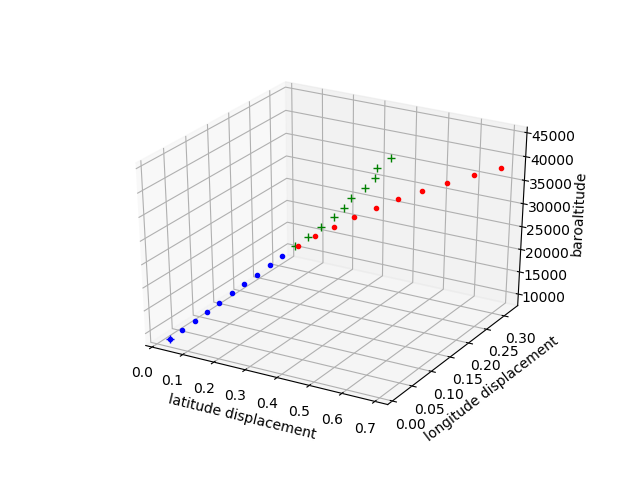

[[ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]
 [ 1.11383865  0.24628703 -0.05127144]]
Variable containing:
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
 1.1138  0.2463 -0.0513
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.10394808  0.24654279  0.03564567]
 [ 1.09676953  0.24716424  0.07034316]
 [ 1.08884295  0.24893384  0.10375809]
 [ 1.08007762  0.25165254  0.13594916]
 [ 1.07047972  0.25525984  0.16681228]
 [ 1.06007524  0.25971317  0.19633599]
 [ 1.04889431  0.26497853  0.22452285]
 [ 1.03696849  0.271023

<IPython.core.display.Javascript object>


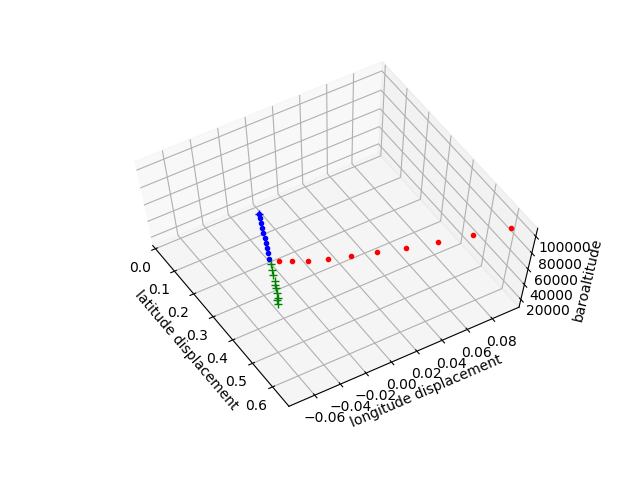

[[ 1.1809572  -3.56445659 -3.35354515]
 [ 1.1809572  -0.15855734 -0.17424611]
 [ 1.1809572  -0.1862774  -0.19948995]
 [ 1.1809572  -0.16712925 -0.18191901]
 [ 1.1809572  -0.16175794 -0.17761122]
 [ 1.1809572  -0.13630365 -0.15380331]
 [ 1.1809572  -0.15756705 -0.17274441]
 [ 1.1809572  -0.17268277 -0.18784906]
 [ 1.1809572  -0.15568155 -0.17138521]
 [ 1.1809572  -0.14378229 -0.16044585]]
Variable containing:
 1.1810 -3.5645 -3.3535
 1.1810 -0.1586 -0.1742
 1.1810 -0.1863 -0.1995
 1.1810 -0.1671 -0.1819
 1.1810 -0.1618 -0.1776
 1.1810 -0.1363 -0.1538
 1.1810 -0.1576 -0.1727
 1.1810 -0.1727 -0.1878
 1.1810 -0.1557 -0.1714
 1.1810 -0.1438 -0.1604
[torch.DoubleTensor of size 10x3]

Test prediction:
[[ 1.19242084 -0.15096981 -0.0315089 ]
 [ 1.19283306 -0.14941119  0.02047378]
 [ 1.19173565 -0.1449592   0.06945234]
 [ 1.18901316 -0.13809618  0.11601193]
 [ 1.18467439 -0.1290662   0.16014862]
 [ 1.17875946 -0.11810726  0.20200555]
 [ 1.1713221  -0.10542908  0.24169969]
 [ 1.16242633 -0.091225

<IPython.core.display.Javascript object>


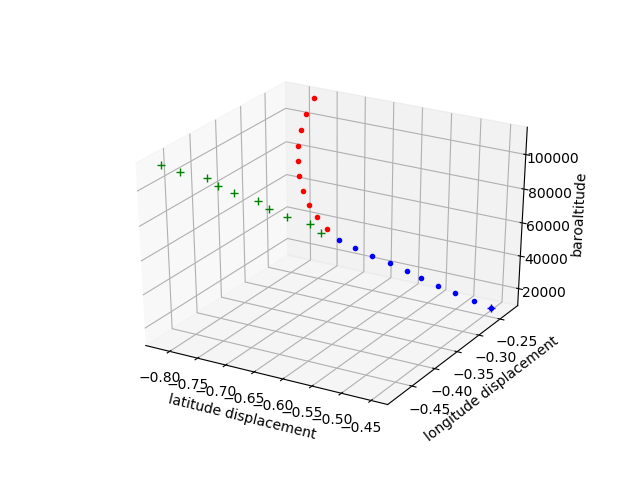

[[-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]
 [-0.31075249  0.20909603  0.24923221]]
Variable containing:
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
-0.3108  0.2091  0.2492
[torch.DoubleTensor of size 10x3]

Test prediction:
[[-0.35310385  0.28925848  0.2835694 ]
 [-0.37455012  0.32505395  0.29645633]
 [-0.39625309  0.36025791  0.30880875]
 [-0.41844039  0.39457386  0.31987677]
 [-0.44132856  0.42761689  0.32970052]
 [-0.46506312  0.45917814  0.33824949]
 [-0.48974426  0.48907476  0.34560983]
 [-0.51545204  0.517174

<IPython.core.display.Javascript object>


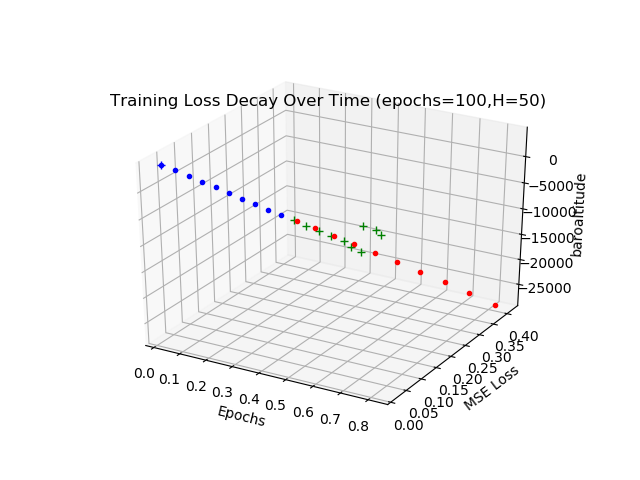

In [43]:
seq = Sequence()
params = torch.load('50_params_epoch10.pt')
seq.load_state_dict(params)
seq.double()

def denormalize(path):
    path *= np.load(filename + "_model_stdevs.npy")
    path += np.load(filename + "_model_means.npy")
    
    return path

future = 10
test_pred = seq(test_input,future).data.squeeze(1).numpy()
test_pred_latlon = test_pred[:, :, -3:]
test_target_latlon = test_target[:, :, -3:]
i = 1
print('test_input', test_input[i])
print('test_target', test_target[i])
print('batch', batch[i])
offset = 0
for i in range(offset,test_input.size(0)//5+offset):
    latlon = test_input[i].data.numpy()[:, -3:]
    target_latlon = test_target_latlon[i].data.numpy()
    
    print(latlon)
    latlon = np.insert(latlon, latlon.shape[0], test_pred_latlon[i], axis=0)
    path = latlon.cumsum(axis=0)
    
    target_path = target_latlon.cumsum(axis=0) + path[-future-1]
    path = denormalize(path)
    target_path = denormalize(target_path)
    print(test_input[i])
    print("Test prediction:")
    print(test_pred[i])
    print("Path including prediction")
    print(path)
    pathz, pathx, pathy = np.split(path, 3, axis=1)
    pathz = pathz.flatten()
    
    target_pathz, target_pathx, target_pathy = np.split(target_path, 3, axis=1)
    target_pathz = target_pathz.flatten()
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel('latitude displacement')
    ax.set_ylabel('longitude displacement')
    ax.set_zlabel('baroaltitude')
    ax.plot(pathx[0], pathy[0], pathz[0], 'b+')
    
    ax.plot(pathx[:-future], pathy[:-future], pathz[:-future], 'b.')
    ax.plot(target_pathx, target_pathy, target_pathz, 'g+')
    
#     print(pathx.shape)
    for j in range(1,future+1):
        plt.plot(pathx[-j], pathy[-j], pathz[-j], 'r.')
    
    plt.show()

## How to save and load models in pytorch

In [ ]:
# Self explanatory comment: Save only
torch.save(seq.state_dict(), filename + 'ACAS_theparameters.pt')

In [43]:
# Self explanatory comment #2: Load only
seq = Sequence()
params = torch.load('50_params_epoch40.pt')
seq.load_state_dict(params)
seq.double()
pred = seq(test_input, future = future)
loss = criterion(pred, test_target)
print('test loss:', loss.data.numpy()[0])


torch.Size([100, 10, 3])
test loss: 6.94889740105e+22


### Making predictions and saving to csvs

- Denormalizes data according to model_stdevs.npy and model_means.npy
- Saves input sequences in "sequence/" folder, and their corresponding predictions in "prediction/" folder. 

In [ ]:
# write to csv file
sequence_dir = 'sequences/'
pred_dir = 'predictions/'
if not os.path.exists(sequence_dir):
    os.makedirs(sequence_dir)
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

# create empty df to store the predictions
pred_df = pd.DataFrame(columns=['baroaltitude','lat','lon'])

# number of future time steps
future = 10
test_pred = seq(test_input,future).data.squeeze(1).numpy()
test_pred_latlon = test_pred[:, :, -3:]

# same logic as above, when we printed and visualized data
for i in range(test_input.size(0)):
    latlon = test_input[i].data.numpy()[:, -3:]
    latlon = np.insert(latlon, latlon.shape[0], test_pred_latlon[i], axis=0)
    
    # path prediction
    path = latlon.cumsum(axis=0)
    path = denormalize(path)
    pathz, pathx, pathy = np.split(path, 3, axis=1)
    pathz = pathz.flatten()
    
    one_seq_df = pd.DataFrame(path[:-future], columns = ['baroaltitude', 'lat', 'lon'])
    one_pred_df = pd.DataFrame(path[future:], columns = ['baroaltitude', 'lat', 'lon'])
    
    one_seq_df.to_csv(sequence_dir + filename + "_sequence_" + str(i) + ".csv", index=False)
    one_pred_df.to_csv(pred_dir + filename + "_sequence-pred_" + str(i) + ".csv", index=False)
    

In [ ]:
def polyfit(states):
    train_Xs, train_Ys, train_Zs = np.split(states, 3, axis=1)
    train_ts = np.arange(states.shape[0])
    
    fitx = np.poly1d(np.polyfit(train_ts, train_Xs))
    fity = np.poly1d(np.polyfit(train_ts, train_Ys))
    fitz = np.poly1d(np.polyfit(train_ts, train_Zs))
    
    def fit(t):
        return (fitx(t), fity(t), fitz(t))
    
    return fit

In [ ]:

fit = polyfit(test_input[0])
compare_criterion = nn.MSELoss()
baseline_pred = 
compare_loss = compare_criterion(baseline_pred, test_target[0])

In [ ]:
test_input.shape